In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math
from math import log10
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
%matplotlib inline
start_time = pd.datetime.now()

In [2]:
card = pd.read_csv('transaction_cleaned.csv')
card['Date'] = pd.to_datetime(card['Date'], infer_datetime_format=True)
card.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Most_common_merch_per_descrip,Most_common_merch_per_card,Most_common_state,Most_common_zip,card_merch,card_zip,card_state
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,5509006296254,930090121224,TN,38118.0,5142190439_5509006296254,5142190439_38118.0,5142190439_TN
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,61003026333,6005030600003,MA,1803.0,5142183973_61003026333,5142183973_1803.0,5142183973_MA
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,4503082993600,7593860068556,MD,20706.0,5142131721_4503082993600,5142131721_20706.0,5142131721_MD
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,5509006296254,930090121224,TN,38118.0,5142148452_5509006296254,5142148452_38118.0,5142148452_TN
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,5509006296254,930090121224,TN,38118.0,5142190439_5509006296254,5142190439_38118.0,5142190439_TN


In [3]:
df = pd.read_csv('variables_with_benford.csv')
df.head()

,Recnum,Amount,Cardnum_daysince,Cardnum_fre_0,Cardnum_mean_0,Cardnum_actual/_mean_0,Cardnum_max_0,Cardnum_actual/_max_0,Cardnum_median_0,Cardnum_actual/_median_0,...,num/amount1Merchnum14,amount/num1Merchnum14,amount/amount1Merchnum14,num/num1Merchnum30,num/amount1Merchnum30,amount/num1Merchnum30,amount/amount1Merchnum30,risk_week,Benford_Card,Benford_Merch
0,1,3.62,365.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,...,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.025994,1.000000,1.000000
1,2,31.42,365.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,...,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.025994,1.000894,1.000894
2,3,178.49,365.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,...,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.025994,1.000894,1.000894
3,4,3.62,365.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,...,3.867403,50.68,14.0,30.0,8.287293,108.6,30.0,0.025994,1.000000,1.000000
4,5,3.62,0.0,1.0,3.62,1.0,3.62,1.0,3.62,1.0,...,3.867403,50.68,14.0,30.0,8.287293,108.6,30.0,0.025994,1.000000,1.000000


In [4]:
dfscaler = df.drop(['Amount','Recnum'],axis=1)
cols = dfscaler.columns.to_series()[np.isinf(dfscaler).any()]
for x in cols:
    dfscaler[x].replace([np.inf],max(dfscaler[x].replace(np.inf, np.nan)),inplace=True)
dfscaler = pd.DataFrame(StandardScaler().fit_transform(dfscaler),columns=dfscaler.columns)
dfscaler.head()

,Cardnum_daysince,Cardnum_fre_0,Cardnum_mean_0,Cardnum_actual/_mean_0,Cardnum_max_0,Cardnum_actual/_max_0,Cardnum_median_0,Cardnum_actual/_median_0,Cardnum_total_0,Cardnum_actual/_total_0,...,num/amount1Merchnum14,amount/num1Merchnum14,amount/amount1Merchnum14,num/num1Merchnum30,num/amount1Merchnum30,amount/num1Merchnum30,amount/amount1Merchnum30,risk_week,Benford_Card,Benford_Merch
0,7.346025,-0.245524,-0.262690,-0.026677,-0.236240,-0.025154,-0.256650,-0.028984,-0.110387,-0.022632,...,-0.013498,-0.208071,-0.541872,-0.473163,-0.009680,-0.178840,-0.441987,3.190701,-0.262320,-0.111549
1,7.346025,-0.245524,-0.262690,-0.026677,-0.236240,-0.025154,-0.256650,-0.028984,-0.110387,-0.022632,...,-0.013498,-0.208071,-0.541872,-0.473163,-0.009680,-0.178840,-0.441987,3.190701,-0.261611,-0.111349
2,7.346025,-0.245524,-0.262690,-0.026677,-0.236240,-0.025154,-0.256650,-0.028984,-0.110387,-0.022632,...,-0.013498,-0.208071,-0.541872,-0.473163,-0.009680,-0.178840,-0.441987,3.190701,-0.261611,-0.111349
3,7.346025,-0.245524,-0.262690,-0.026677,-0.236240,-0.025154,-0.256650,-0.028984,-0.110387,-0.022632,...,0.841861,-0.196163,3.212381,4.237607,0.846631,-0.164571,4.067078,3.190701,-0.262320,-0.111549
4,-0.222747,-0.078915,-0.255398,-0.014161,-0.231503,-0.012626,-0.249162,-0.016534,-0.109231,-0.010056,...,0.841861,-0.196163,3.212381,4.237607,0.846631,-0.164571,4.067078,3.190701,-0.262320,-0.111549


In [5]:
start_date = '2010-01-15'
end_date = '2010-10-31'

In [6]:
card2 = card[(card['Date'] >= start_date) & (card['Date'] <= end_date)].reset_index(drop=True)
card2.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Most_common_merch_per_descrip,Most_common_merch_per_card,Most_common_state,Most_common_zip,card_merch,card_zip,card_state
0,3345,5142289869,2010-01-15,602608969534,FISHER SCI ATL,GA,30091.0,P,333.47,0,602608969534,602608969284,GA,30091.0,5142289869_602608969534,5142289869_30091.0,5142289869_GA
1,3346,5142148452,2010-01-15,5509006296254,FEDEX SHP 01/10/10 AB#,TN,38118.0,P,4.37,0,5509006296254,930090121224,TN,38118.0,5142148452_5509006296254,5142148452_38118.0,5142148452_TN
2,3347,5142184598,2010-01-15,680655463,MC MASTER CARR SUPP,IL,60126.0,P,271.93,0,935610288226,935610288226,IL,60126.0,5142184598_680655463,5142184598_60126.0,5142184598_IL
3,3348,5142148452,2010-01-15,5509006296254,FEDEX SHP 01/10/10 AB#,TN,38118.0,P,3.62,0,5509006296254,930090121224,TN,38118.0,5142148452_5509006296254,5142148452_38118.0,5142148452_TN
4,3349,5142195887,2010-01-15,4503082616100,OFFICE DEPOT #122,NC,27707.0,P,16.28,0,4503082616100,4503082616100,NC,27707.0,5142195887_4503082616100,5142195887_27707.0,5142195887_NC


In [7]:
df1 = pd.concat([card.Date,df], axis=1)
df2 = df1[(df1['Date'] >= start_date) & (df1['Date'] <= end_date)].reset_index(drop=True).drop(['Date','Amount','Recnum'],axis=1)
df2['Fraud'] = card2['Fraud']
df2['RandNum'] = np.random.randint(1,100,size=len(df2))
df2.head()

,Cardnum_daysince,Cardnum_fre_0,Cardnum_mean_0,Cardnum_actual/_mean_0,Cardnum_max_0,Cardnum_actual/_max_0,Cardnum_median_0,Cardnum_actual/_median_0,Cardnum_total_0,Cardnum_actual/_total_0,...,amount/amount1Merchnum14,num/num1Merchnum30,num/amount1Merchnum30,amount/num1Merchnum30,amount/amount1Merchnum30,risk_week,Benford_Card,Benford_Merch,Fraud,RandNum
0,1.0,0.0,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.025994,2.532587,1.083379,0,43
1,1.0,0.0,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,...,0.683121,0.098361,0.016086,8.95082,1.463831,0.025994,1.000000,1.000000,0,34
2,1.0,0.0,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,...,1.537712,5.000000,0.021190,777.52500,3.295098,0.025994,1.164093,1.357196,0,25
3,0.0,1.0,4.37,0.828375,4.37,0.828375,4.37,0.828375,4.37,0.828375,...,0.714252,0.196078,0.032097,9.35000,1.530540,0.025994,1.000000,1.000000,0,95
4,365.0,0.0,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.025994,1.000894,1.022183,0,33


In [8]:
goods = df2[df2['Fraud'] == 0]
bads = df2[df2['Fraud'] == 1]
numgoods=len(goods)
numbads=len(bads)

In [9]:
KSFDR = pd.DataFrame(columns=['Field','KS'])
for column in df2:
    KSFDR = KSFDR.append({'Field': column, 'KS': sps.ks_2samp(goods[column],bads[column])[0]}, ignore_index=True)
KSFDR

,Field,KS
0,Cardnum_daysince,0.291223
1,Cardnum_fre_0,0.339447
2,Cardnum_mean_0,0.462401
3,Cardnum_actual/_mean_0,0.303057
4,Cardnum_max_0,0.465901
...,...,...
323,risk_week,0.134586
324,Benford_Card,0.370092
325,Benford_Merch,0.308931
326,Fraud,1.000000


In [10]:
KSFDR2 = pd.DataFrame()
topRows = int(round(len(df2)*0.03))
j = 0
for column in df2:
    temp1 = df2.sort_values(column,ascending=False).head(topRows)
    temp2 = df2.sort_values(column,ascending=True).head(topRows)
    needed1 = temp1.loc[:,'Fraud']
    needed2 = temp2.loc[:,'Fraud']
    FDR1 = sum(needed1)/numbads
    FDR2 = sum(needed2)/numbads
    FDRate = np.maximum(FDR1,FDR2)
    KSFDR2.loc[j, 'FDR'] = FDRate
    j = j +1
KSFDR2

,FDR
0,0.061060
1,0.171659
2,0.412442
3,0.029954
4,0.430876
...,...
323,0.063364
324,0.203917
325,0.179724
326,1.000000


In [11]:
KSFDR = pd.concat([KSFDR,KSFDR2], axis=1)
KSFDR

,Field,KS,FDR
0,Cardnum_daysince,0.291223,0.061060
1,Cardnum_fre_0,0.339447,0.171659
2,Cardnum_mean_0,0.462401,0.412442
3,Cardnum_actual/_mean_0,0.303057,0.029954
4,Cardnum_max_0,0.465901,0.430876
...,...,...,...
323,risk_week,0.134586,0.063364
324,Benford_Card,0.370092,0.203917
325,Benford_Merch,0.308931,0.179724
326,Fraud,1.000000,1.000000


In [12]:
KSFDR['rank_KS'] = KSFDR['KS'].rank(ascending = True)
KSFDR['rank_FDR'] = KSFDR['FDR'].rank(ascending = True)
KSFDR['average_rank'] = (KSFDR['rank_KS'] + KSFDR['rank_FDR']) / 2
KSFDR

,Field,KS,FDR,rank_KS,rank_FDR,average_rank
0,Cardnum_daysince,0.291223,0.061060,96.0,129.5,112.75
1,Cardnum_fre_0,0.339447,0.171659,160.0,187.0,173.50
2,Cardnum_mean_0,0.462401,0.412442,285.0,296.0,290.50
3,Cardnum_actual/_mean_0,0.303057,0.029954,111.0,40.0,75.50
4,Cardnum_max_0,0.465901,0.430876,288.0,308.0,298.00
...,...,...,...,...,...,...
323,risk_week,0.134586,0.063364,2.0,133.5,67.75
324,Benford_Card,0.370092,0.203917,200.0,198.0,199.00
325,Benford_Merch,0.308931,0.179724,116.0,188.0,152.00
326,Fraud,1.000000,1.000000,328.0,328.0,328.00


In [13]:
var = KSFDR.sort_values(by=['average_rank'], ascending=False)
var = var.iloc[1:81,:]
var

,Field,KS,FDR,rank_KS,rank_FDR,average_rank
255,card_state_total_7,0.552733,0.505760,326.0,326.0,326.00
26,Cardnum_total_3,0.536278,0.528802,324.0,327.0,325.50
35,Cardnum_total_7,0.555182,0.494240,327.0,324.0,325.50
246,card_state_total_3,0.540805,0.486175,325.0,323.0,324.00
17,Cardnum_total_1,0.518122,0.501152,318.0,325.0,321.50
...,...,...,...,...,...,...
224,card_state_max_0,0.388235,0.402074,208.0,291.0,249.50
84,Merchnum_mean_7,0.469744,0.250000,290.0,209.0,249.50
214,card_zip_max_30,0.439128,0.315668,260.0,237.5,248.75
321,amount/num1Merchnum30,0.426939,0.368664,236.0,261.5,248.75


In [14]:
KSFDR.to_csv('KSFDR.csv')

In [15]:
df3 = pd.concat([card.Date,dfscaler], axis=1)
df3.head()

,Date,Cardnum_daysince,Cardnum_fre_0,Cardnum_mean_0,Cardnum_actual/_mean_0,Cardnum_max_0,Cardnum_actual/_max_0,Cardnum_median_0,Cardnum_actual/_median_0,Cardnum_total_0,...,num/amount1Merchnum14,amount/num1Merchnum14,amount/amount1Merchnum14,num/num1Merchnum30,num/amount1Merchnum30,amount/num1Merchnum30,amount/amount1Merchnum30,risk_week,Benford_Card,Benford_Merch
0,2010-01-01,7.346025,-0.245524,-0.262690,-0.026677,-0.236240,-0.025154,-0.256650,-0.028984,-0.110387,...,-0.013498,-0.208071,-0.541872,-0.473163,-0.009680,-0.178840,-0.441987,3.190701,-0.262320,-0.111549
1,2010-01-01,7.346025,-0.245524,-0.262690,-0.026677,-0.236240,-0.025154,-0.256650,-0.028984,-0.110387,...,-0.013498,-0.208071,-0.541872,-0.473163,-0.009680,-0.178840,-0.441987,3.190701,-0.261611,-0.111349
2,2010-01-01,7.346025,-0.245524,-0.262690,-0.026677,-0.236240,-0.025154,-0.256650,-0.028984,-0.110387,...,-0.013498,-0.208071,-0.541872,-0.473163,-0.009680,-0.178840,-0.441987,3.190701,-0.261611,-0.111349
3,2010-01-01,7.346025,-0.245524,-0.262690,-0.026677,-0.236240,-0.025154,-0.256650,-0.028984,-0.110387,...,0.841861,-0.196163,3.212381,4.237607,0.846631,-0.164571,4.067078,3.190701,-0.262320,-0.111549
4,2010-01-01,-0.222747,-0.078915,-0.255398,-0.014161,-0.231503,-0.012626,-0.249162,-0.016534,-0.109231,...,0.841861,-0.196163,3.212381,4.237607,0.846631,-0.164571,4.067078,3.190701,-0.262320,-0.111549


In [17]:
df4 = df3[(df3['Date'] >= start_date) & (df3['Date'] <= end_date)].reset_index(drop=True).drop(['Date'],axis=1)
df4['Fraud'] = card2['Fraud']
wrap = df4[["Fraud","card_state_total_7","Cardnum_total_3","Cardnum_total_7","card_state_total_3","Cardnum_total_1","card_state_total_14","Cardnum_total_14","card_state_max_3","Cardnum_mean_1","card_state_total_1","Cardnum_max_14","card_state_max_7","Cardnum_max_7","amount/num1Cardnum30","Cardnum_mean_3","Cardnum_max_3","card_zip_total_7","Cardnum_total_0","card_zip_total_3","Cardnum_max_1","card_state_max_1","card_merch_total_14","card_merch_total_7","card_state_total_30","Cardnum_max_0","amount/num1Cardnum14","card_zip_total_14","card_merch_total_3","card_state_mean_3","amount/num1Cardnum7","card_state_median_1","card_state_mean_1","Cardnum_mean_0","Cardnum_mean_7","Cardnum_total_30","card_zip_total_1","card_merch_max_3","Cardnum_median_1","card_state_mean_7","card_state_max_14","card_merch_total_30","card_zip_max_1","card_zip_max_3","card_state_median_3","card_zip_total_30","Cardnum_mean_14","card_merch_max_1","Cardnum_median_0","card_merch_total_1","card_merch_mean_3","amount/num0Cardnum30","Cardnum_median_3","card_state_max_30","card_zip_mean_3","card_state_mean_14","card_merch_median_3","card_zip_median_3","card_zip_max_7","Merchnum_total_1","card_zip_max_14","card_zip_median_1","card_zip_mean_1","card_state_mean_30","card_merch_max_7","card_merch_max_14","Merchnum_total_3","Cardnum_mean_30","Cardnum_max_30","Merchnum_mean_3","Merchnum_mean_1","card_merch_median_1","card_merch_mean_1","card_state_median_7","amount/amount1Cardnum30","amount/num0Cardnum14","Merchnum_mean_7","card_state_max_0","card_zip_max_30","amount/num1Merchnum30","card_zip_mean_7"]]
X = wrap.iloc[:,1:]
Y = wrap.iloc[:,0]

In [18]:
model = LogisticRegression()
rfecv = RFECV(estimator=model, step=1, cv=2, verbose=3, n_jobs=-1, scoring='roc_auc')
rfecv.fit(X, Y)

Fitting estimator with 80 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 79 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 78 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 77 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 76 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 75 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 74 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 73 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 72 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 71 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 70 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 69 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 68 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 67 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 66 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 65 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 64 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 63 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 62 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 61 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 60 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 59 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 58 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 57 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 56 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 55 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 54 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 53 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 52 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 51 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 50 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 49 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 48 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 47 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 46 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 45 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 44 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 43 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 42 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 41 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 40 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 39 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 38 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 37 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 36 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 35 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 34 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 33 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 32 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 31 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 30 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 29 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 28 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 27 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 26 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 25 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 24 features.


C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rajat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


RFECV(cv=2,
      estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='warn', n_jobs=None,
                                   penalty='l2', random_state=None,
                                   solver='warn', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring='roc_auc', step=1,
      verbose=3)

In [19]:
var_selected = pd.DataFrame(sorted(zip(map(lambda x: round(x), rfecv.ranking_), X.columns)),
                            columns = ['ranking', 'variable'])
var_selected

,ranking,variable
0,1,Cardnum_max_30
1,1,Cardnum_total_1
2,1,Cardnum_total_14
3,1,Cardnum_total_30
4,1,Merchnum_total_1
...,...,...
75,54,amount/num1Cardnum30
76,55,amount/num0Cardnum30
77,56,Cardnum_median_1
78,57,card_merch_total_14


In [20]:
var_selected.to_csv('final_vars.csv')

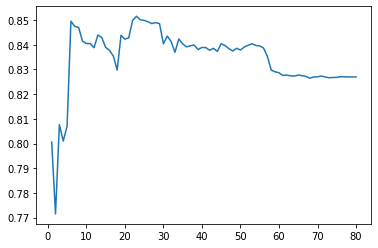

In [21]:
rfecvgrid = pd.Series(rfecv.grid_scores_)
plt.figure()
plt.plot(range(1,len(rfecvgrid)+1), rfecvgrid)
# plt.xlim(0,40)
plt.show()

In [22]:
## step forward feature selection
sfs1 = sfs(LogisticRegression(solver='lbfgs'),
           k_features=30,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5,
           n_jobs=-1)

# Perform SFFS
sfs1 = sfs1.fit(X, Y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   10.2s finished

[2020-04-08 13:22:04] Features: 1/30 -- score: 0.9914797957949473[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:    8.1s finished

[2020-04-08 13:22:12] Features: 2/30 -- score: 0.992050299207107[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:    8.4s finished

[2020-04-08 13:22:20] Features: 3/30 -- score: 0.9923107466341925[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  77 out of

In [23]:
feat_cols = list(sfs1.k_feature_idx_)
X.iloc[:, feat_cols]

,Cardnum_total_3,card_state_total_3,Cardnum_total_1,card_state_total_1,Cardnum_max_1,card_merch_total_14,amount/num1Cardnum14,amount/num1Cardnum7,card_state_mean_1,card_state_median_3,...,Merchnum_total_3,Merchnum_mean_3,Merchnum_mean_1,card_state_median_7,amount/amount1Cardnum30,amount/num0Cardnum14,Merchnum_mean_7,card_state_max_0,card_zip_max_30,card_zip_mean_7
0,0.088284,-0.088275,0.093463,-0.068764,0.557105,0.311858,-0.046082,0.129848,-0.210130,-0.249600,...,-0.150680,-0.122656,-0.327383,1.280953,0.199553,-0.190053,0.119061,-0.136603,0.840698,1.677580
1,-0.049197,-0.043347,-0.010711,-0.068764,0.297140,0.024970,-0.243007,-0.287581,-0.210130,-0.241382,...,-0.089089,-0.363690,-0.145428,-0.295010,2.101937,-0.190053,-0.441344,-0.136603,-0.270952,-0.228990
2,1.214060,0.088058,0.356123,0.012881,0.984234,0.415327,0.030023,0.165811,0.145734,0.353133,...,-0.192742,-0.072813,-0.016450,0.240168,0.341270,-0.190053,-0.147783,-0.136603,0.347845,0.126328
3,-0.048447,-0.042218,-0.009900,-0.067616,0.297140,0.026078,-0.243042,-0.287779,-0.200130,-0.241382,...,-0.088212,-0.363746,-0.232037,-0.295010,2.109642,-0.189863,-0.441364,-0.128919,-0.270952,-0.229005
4,-0.191799,-0.088275,-0.132609,-0.068764,-0.325939,-0.100448,-0.262814,-0.314582,-0.210130,-0.249600,...,-0.232308,-0.154651,-0.327383,-0.302407,-0.510944,-0.190053,0.021717,-0.136603,-0.288633,-0.240337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80627,-0.191799,-0.088275,-0.132609,-0.068764,-0.325939,-0.100448,-0.262814,-0.314582,-0.210130,-0.249600,...,-0.133427,-0.080415,0.510649,-0.302407,-0.510944,-0.190053,0.113042,-0.136603,-0.288633,-0.240337
80628,-0.160897,-0.041813,-0.099190,-0.021516,-0.155121,-0.054832,0.377938,0.210988,0.201744,0.139594,...,-0.135591,-0.144265,-0.009175,0.047941,4.194033,0.739821,-0.219290,0.179881,-0.082000,0.184038
80629,-0.188373,-0.088275,-0.132609,-0.068764,-0.325939,-0.100448,-0.262814,-0.314582,-0.210130,-0.249600,...,-0.255162,-0.378476,-0.327383,-0.302407,-0.510944,-0.190053,-0.453684,-0.136603,-0.288633,-0.240337
80630,-0.191799,-0.088275,-0.132609,-0.068764,-0.325939,-0.100448,-0.262814,-0.314582,-0.210130,-0.249600,...,-0.255162,-0.378476,-0.327383,-0.302407,-0.510944,-0.190053,-0.453684,-0.136603,-0.288633,-0.240337


In [24]:
X.iloc[:, feat_cols].to_csv('fwd.csv')